In [1]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import load_model
from keras import backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.python.framework import ops
from matplotlib import pyplot as plt
import numpy as np
import sys
import cv2

Using TensorFlow backend.


In [2]:
def build_model():
    """Function returning keras model instance.

    Model can be
     - Trained here
     - Loaded with load_model
     - Loaded from keras.applications
    """
    model = load_model('classifier.hdf5', compile=False)
    model.compile(optimizer='sgd', loss='categorical_crossentropy')
    return model

In [3]:
def build_guided_model():
    """Function returning modified model.

    Changes gradient function for all ReLu activations
    according to Guided Backpropagation.
    """
    if 'GuidedBackProp' not in ops._gradient_registry._registry:
        @ops.RegisterGradient('GuidedBackProp')
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = build_model()
    return new_model

def load_mnist():
    print('Loading MNIST')
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = np.expand_dims(x_train, -1) / 255 / 5 + 4 / 5
    x_test = np.expand_dims(x_test, -1) / 255 / 5 + 4 / 5
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()
def load_image(i):
    """Function to load and preprocess image."""
    x = np.expand_dims(x_test[i], 0)
    return x

def guided_backprop_batch(model, imgs, activation_layer):
    """Compute gradients of conv. activation w.r.t. the input image.

    If model is modified properly this will result in Guided Backpropagation
    method for visualizing input saliency.
    See https://arxiv.org/abs/1412.6806 """
    input_imgs = model.input
    layer_output = model.get_layer(activation_layer).output
    grads = K.gradients(layer_output, input_imgs)[0]
    gradient_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = gradient_fn([imgs, 0])[0]
    return grads_val[..., 0]

def grad_cam_batch(input_model, imgs, category_indices, activation_layer):
    """GradCAM method for visualizing input saliency."""
    loss = tf.gather_nd(input_model.output, np.dstack([range(imgs.shape[0]), category_indices])[0])
    layer_output = input_model.get_layer(activation_layer).output
    grads = K.gradients(loss, layer_output)[0]
    gradient_fn = K.function([input_model.input, K.learning_phase()], [layer_output, grads])

    conv_output, grads_val = gradient_fn([imgs, 0])    

    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.einsum('ijkl,il->ijk', conv_output, weights)
    
    new_cams = np.empty((imgs.shape[0], 28, 28))
    for i in range(new_cams.shape[0]):
        tmp = cams[i] - cams[i].mean()
        tmp = (tmp + 1e-10) / (np.linalg.norm(tmp, 2) + 1e-10)
        new_cams[i] = cv2.resize(tmp, (28, 28), cv2.INTER_LINEAR)
        new_cams[i] = np.maximum(new_cams[i], 0)
        new_cams[i] = new_cams[i] / new_cams[i].max()
    
    return new_cams

Loading MNIST


In [4]:
model = build_model()
guided_model = build_guided_model()

In [5]:
def compute_all(model, guided_model, layer_name):
    predictions = model.predict(x_test, batch_size=5000, verbose=True)
    classes = np.argmax(predictions, -1)
    
    gcs = np.empty(x_test.shape[:3])
    gbs = np.empty(x_test.shape[:3])
    ggs = np.empty(x_test.shape[:3])
    
    for batch in range(10):
        start, end = batch * 1000, (batch + 1) * 1000
        gcs[start:end] = grad_cam_batch(model, x_test[start:end], classes[start:end], activation_layer=layer_name)
        gbs[start:end] = guided_backprop_batch(guided_model, imgs=x_test[start:end], activation_layer=layer_name)
        ggs[start:end] = gbs[start:end] * gcs[start:end]

    return gcs, gbs, ggs

In [6]:
gcs, gbs, ggs = compute_all(model, guided_model, 'conv4')

10000/10000 [==============================] - 1s     


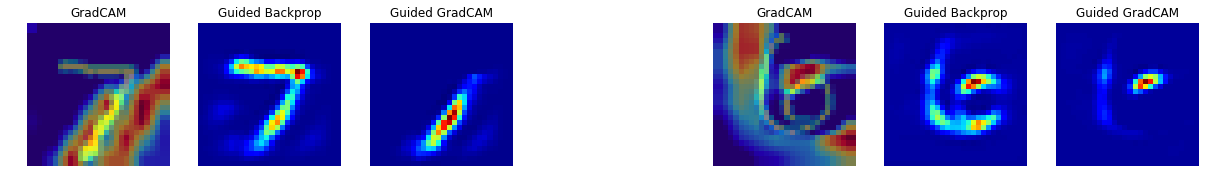

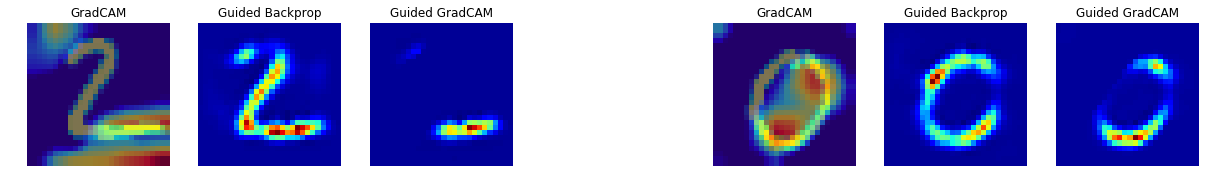

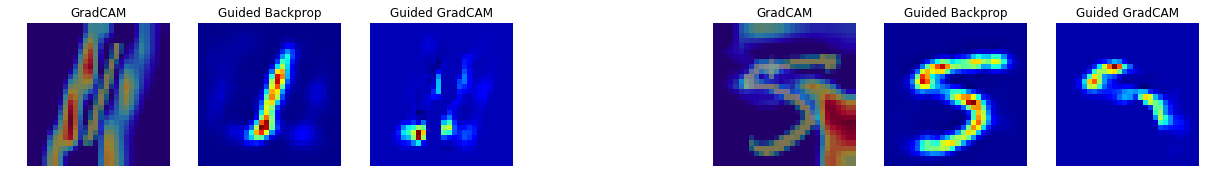

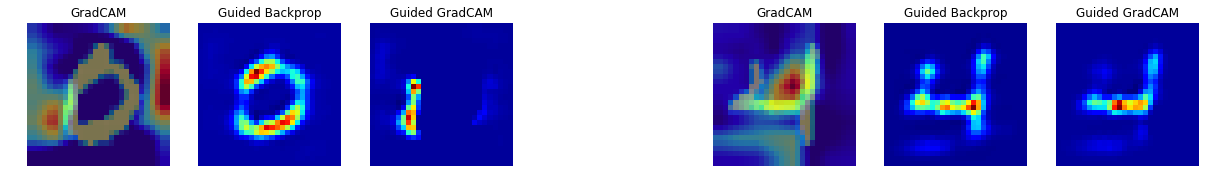

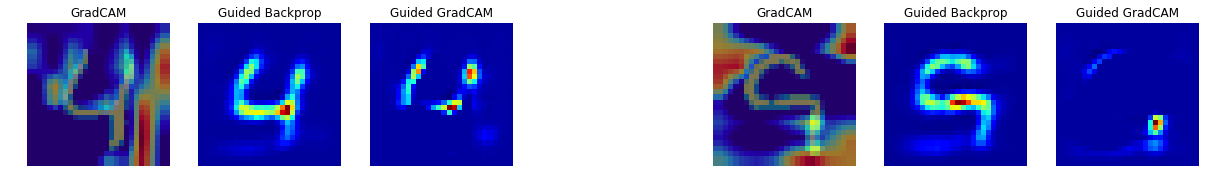

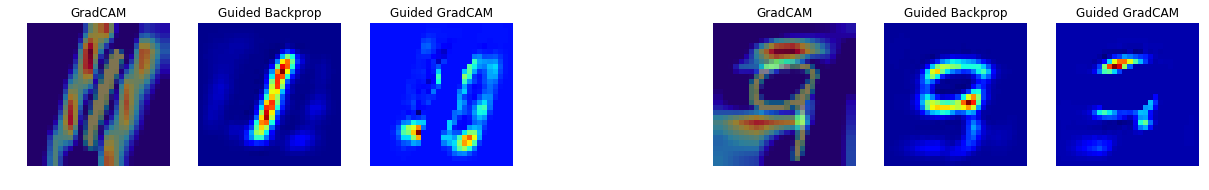

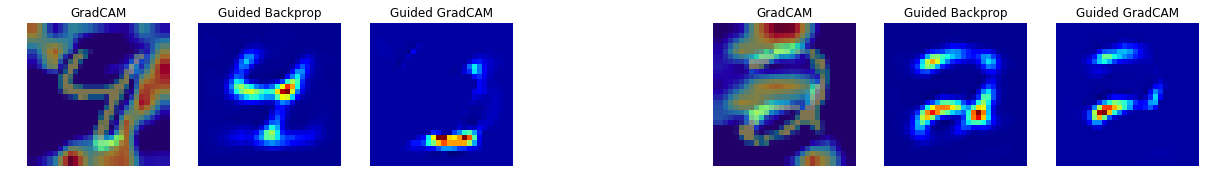

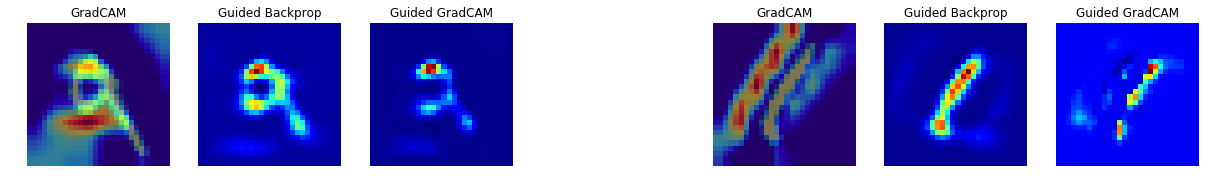

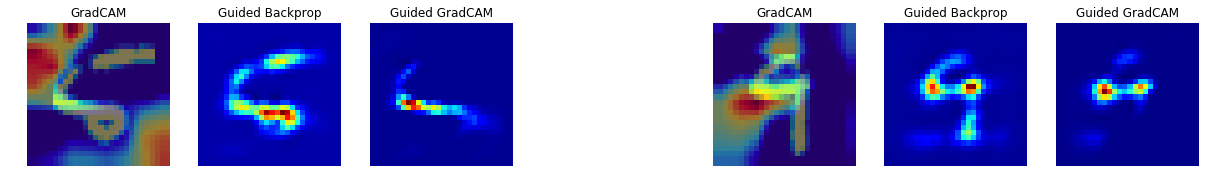

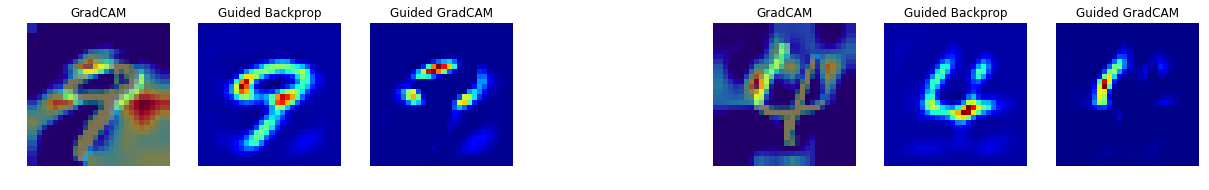

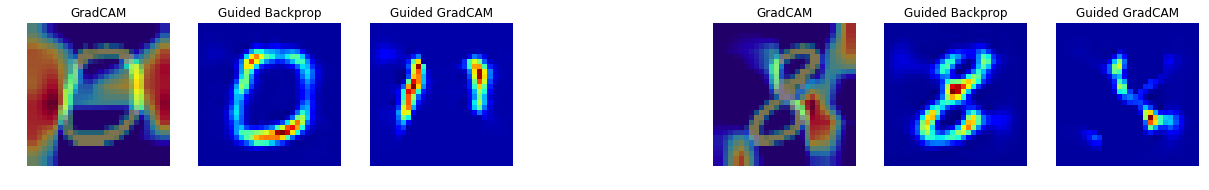

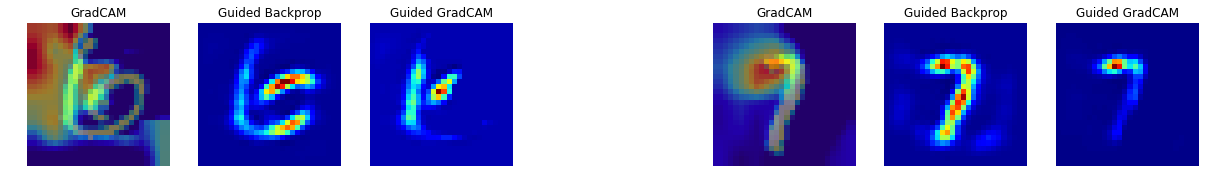

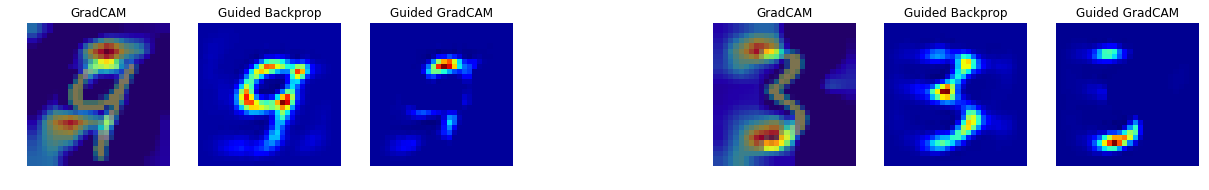

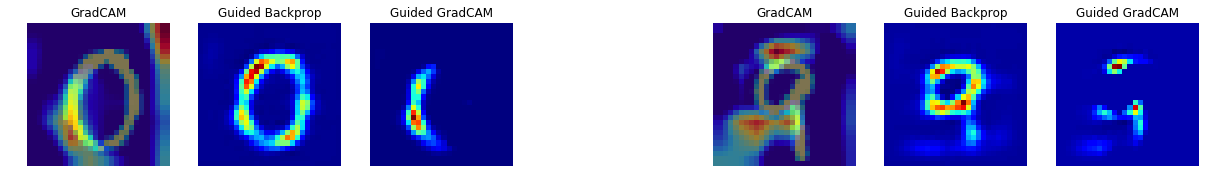

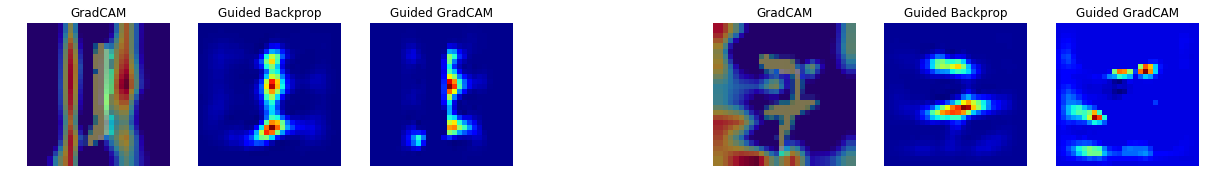

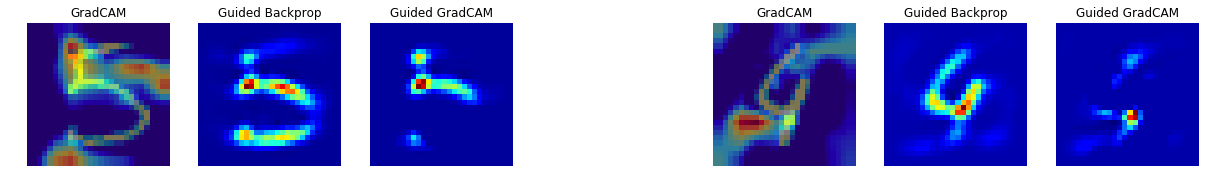

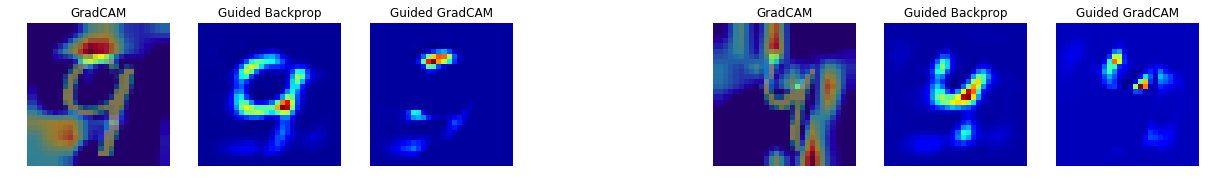

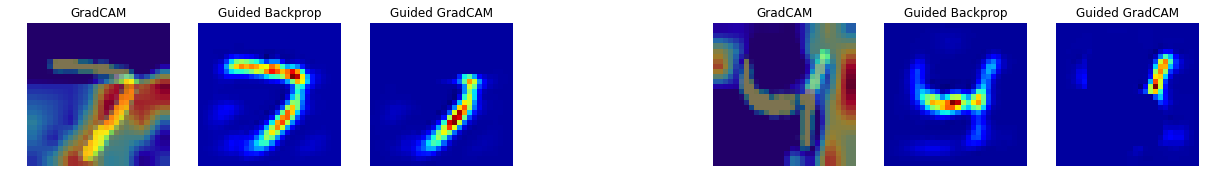

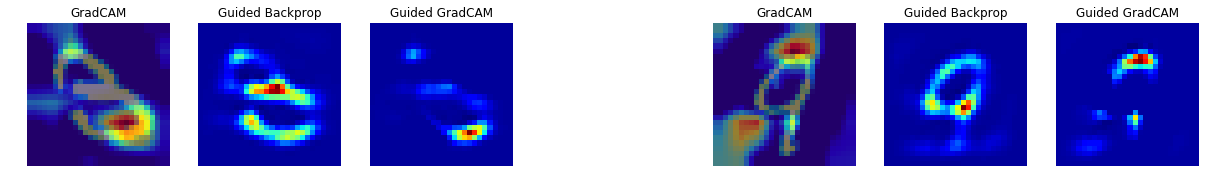

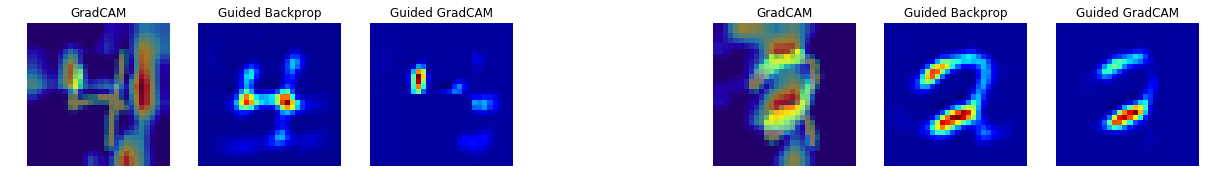

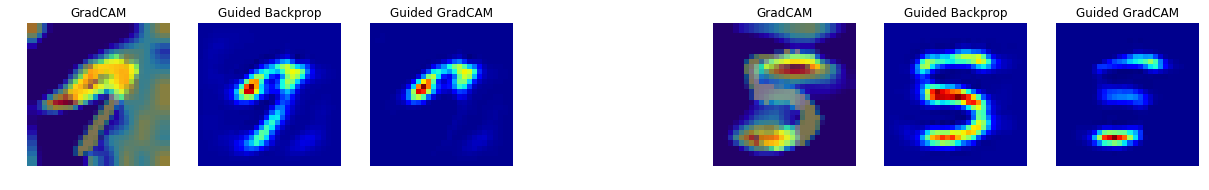

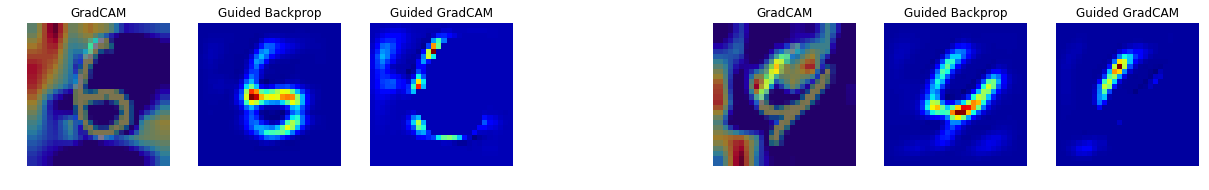

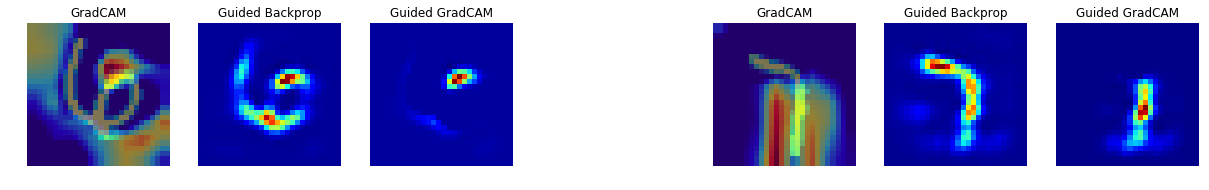

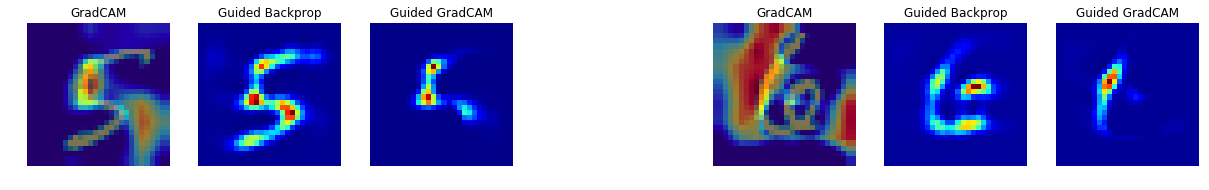

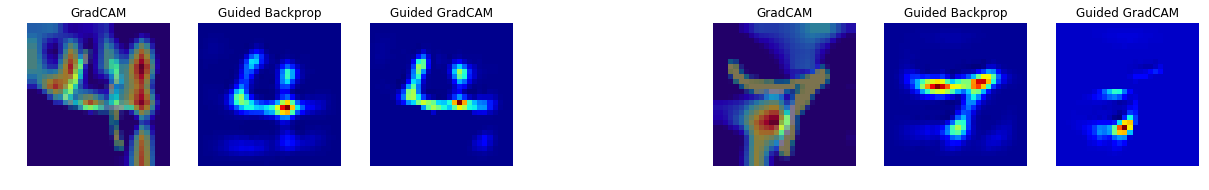

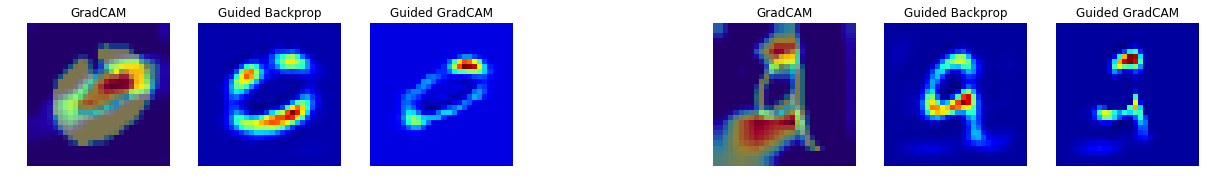

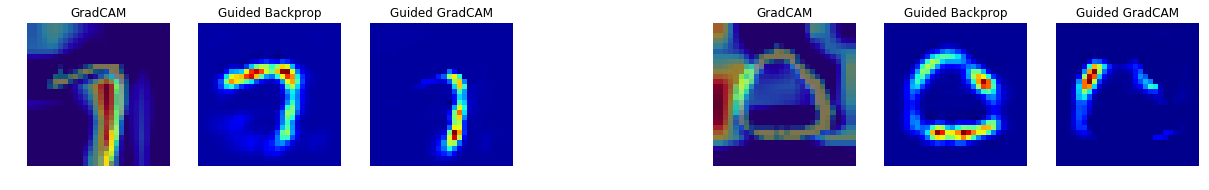

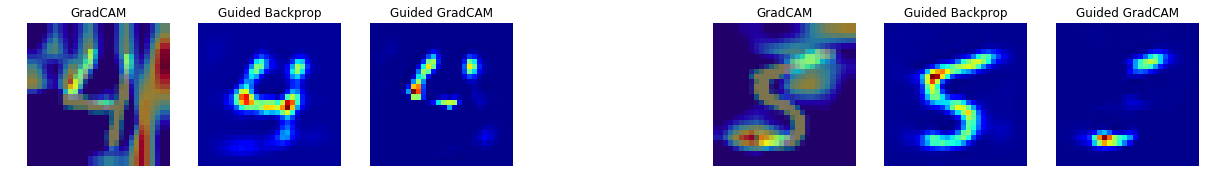

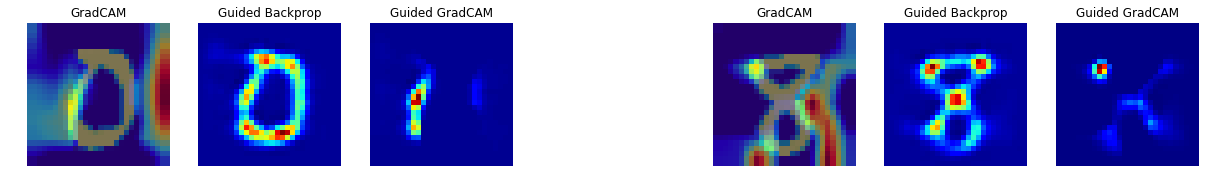

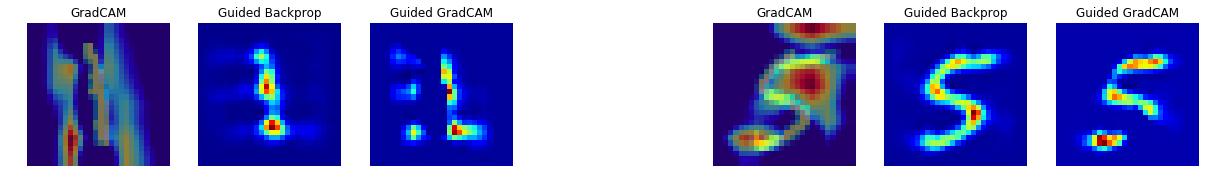

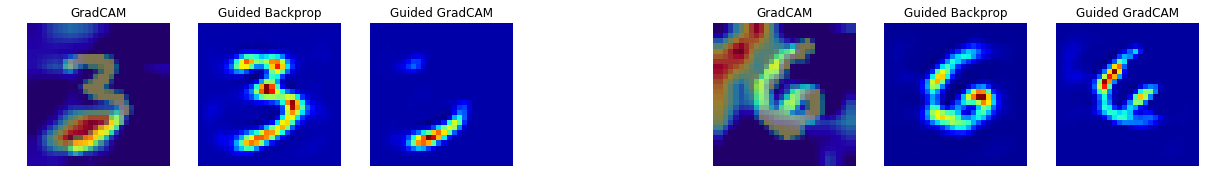

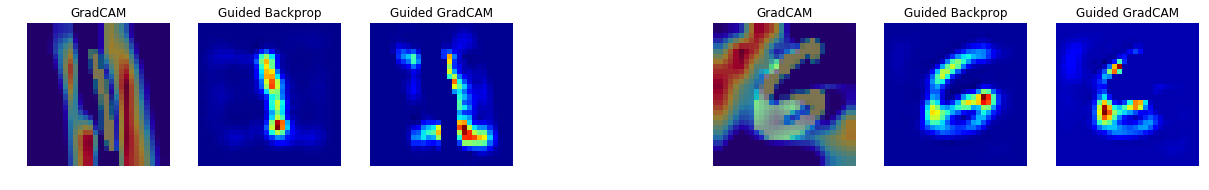

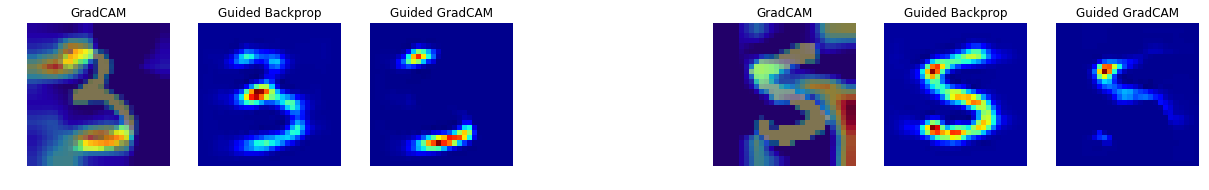

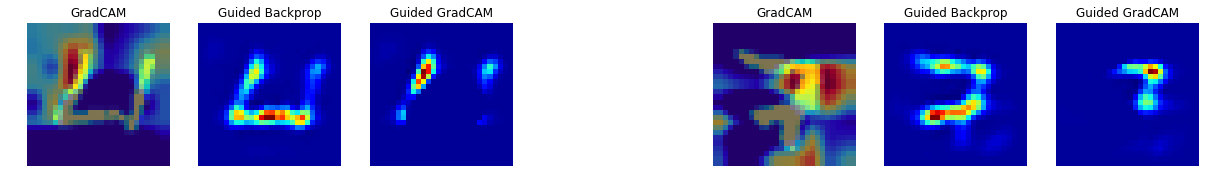

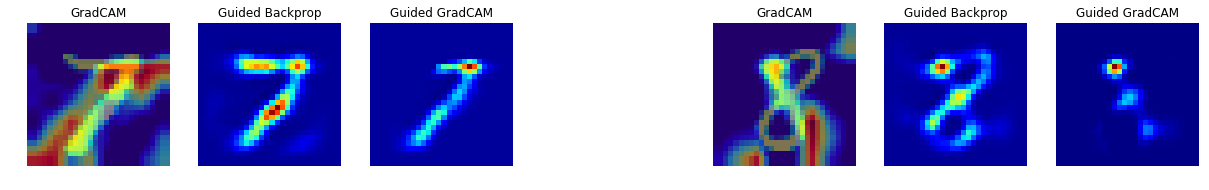

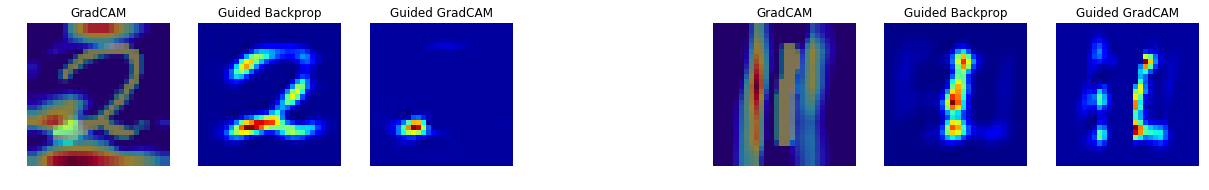

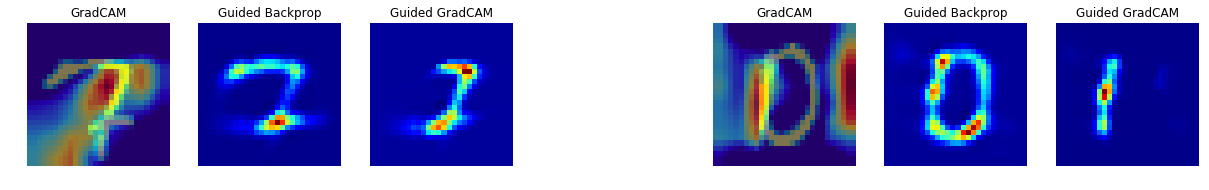

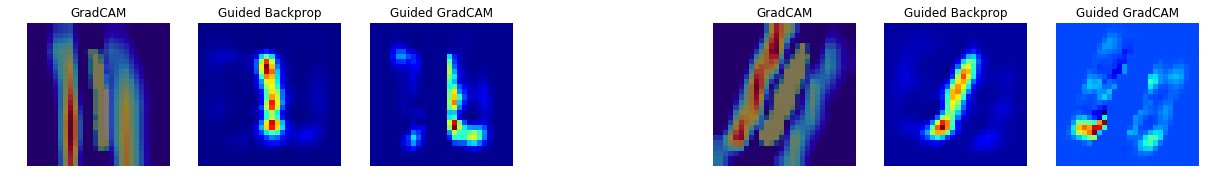

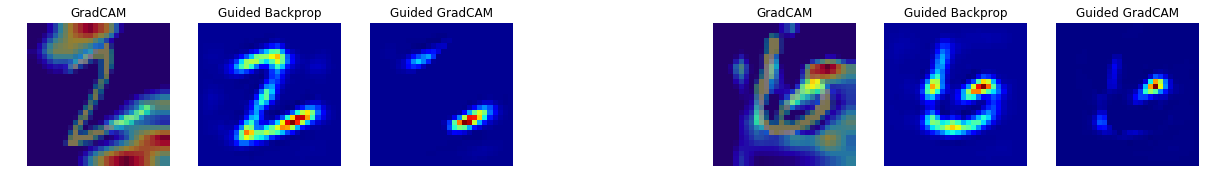

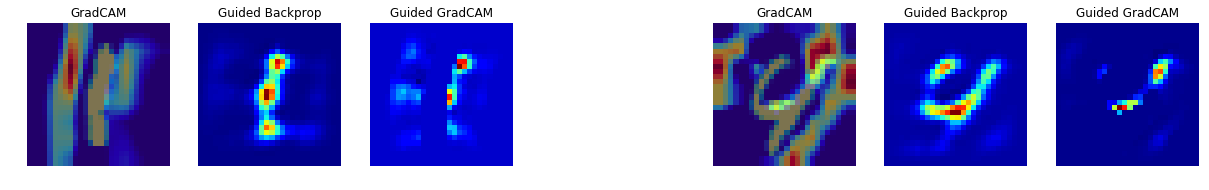

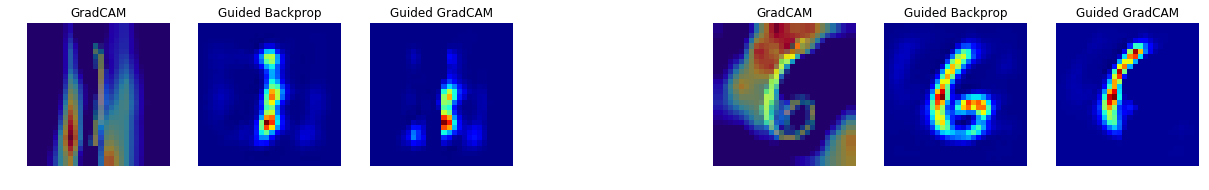

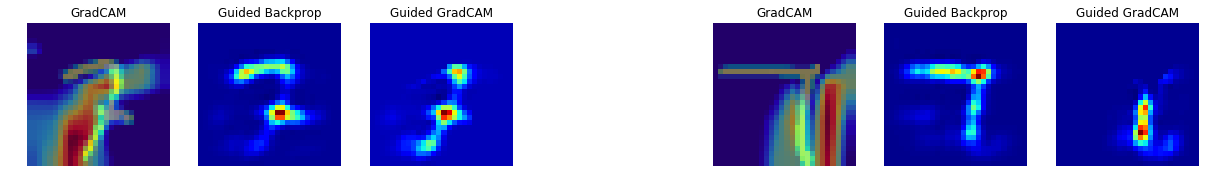

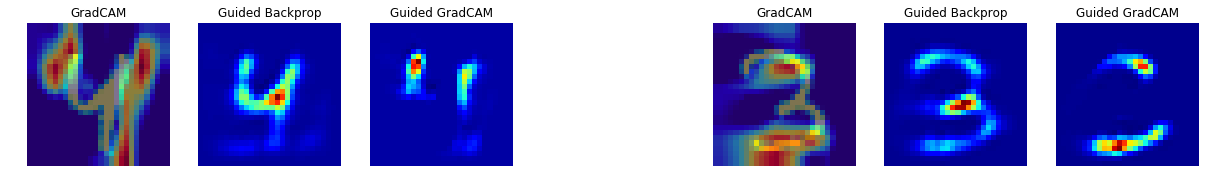

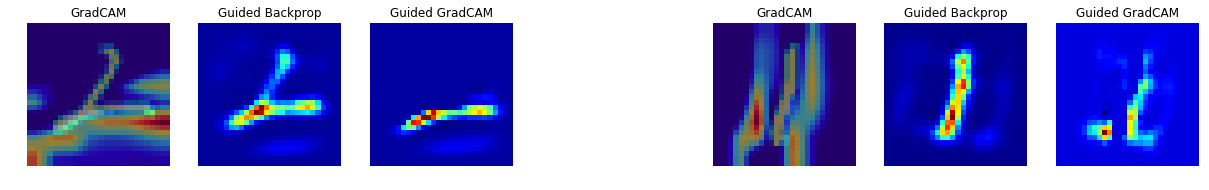

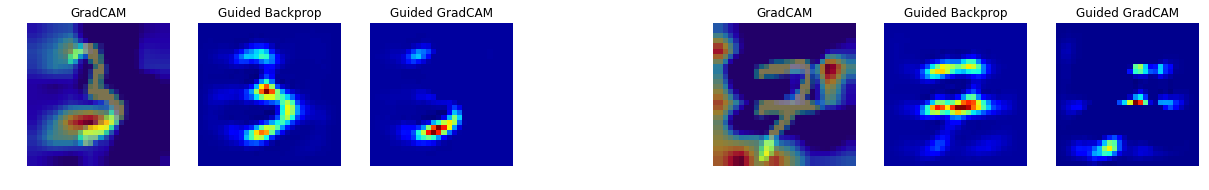

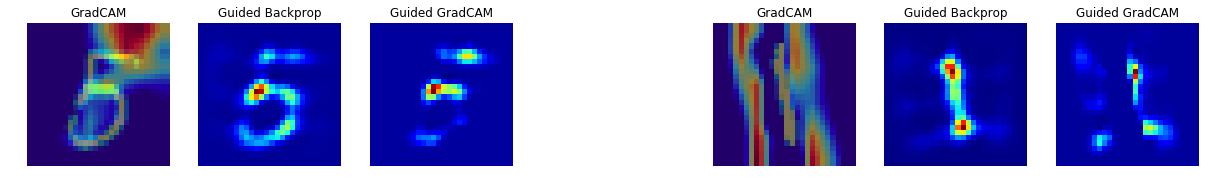

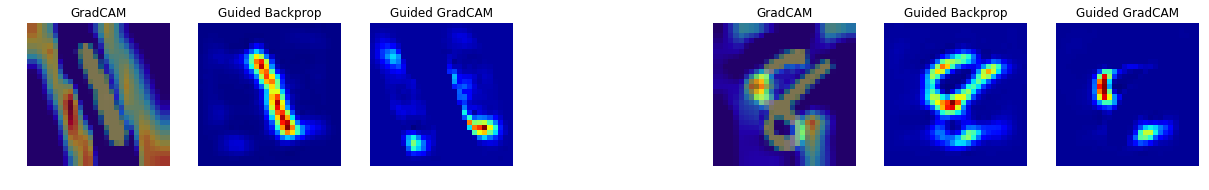

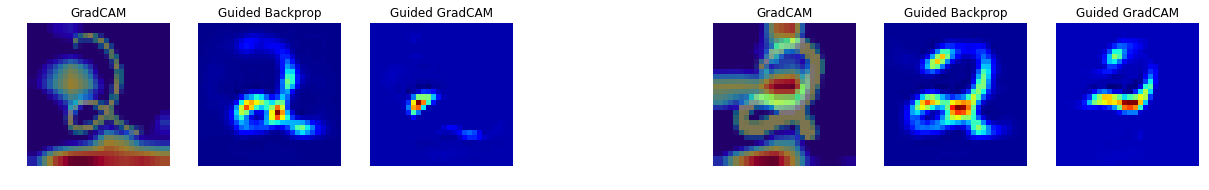

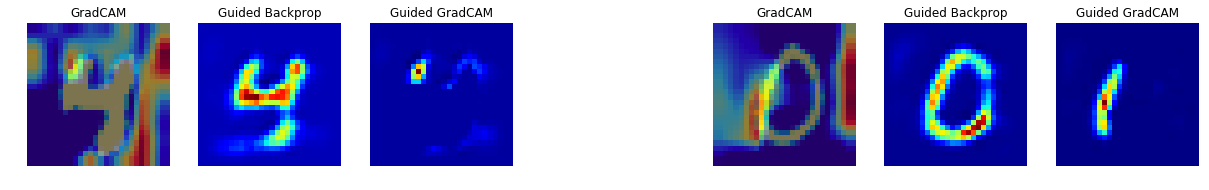

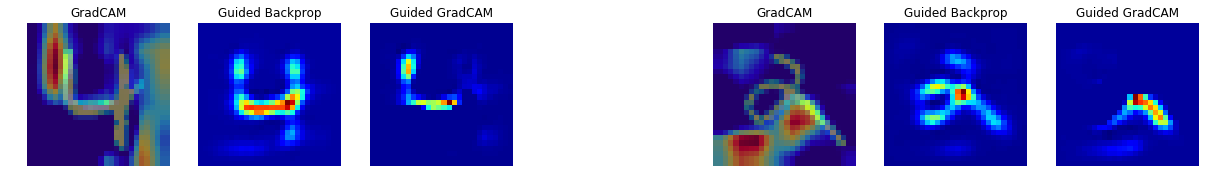

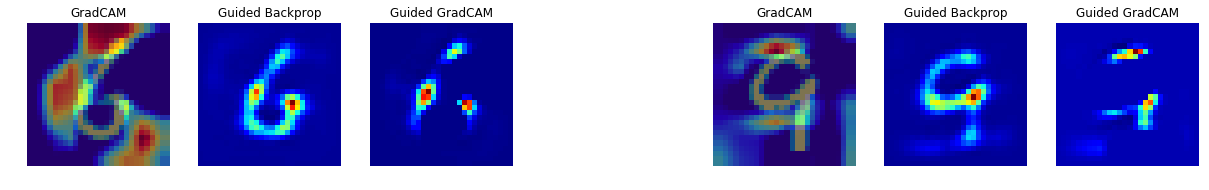

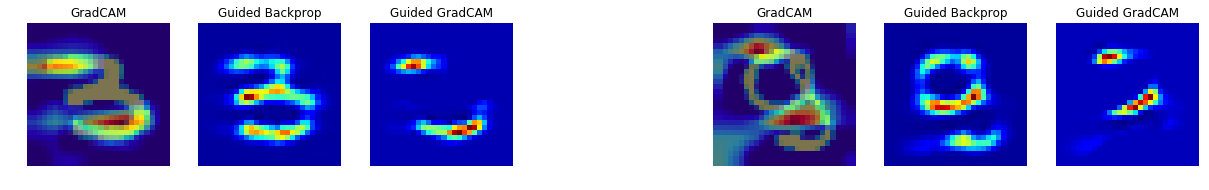

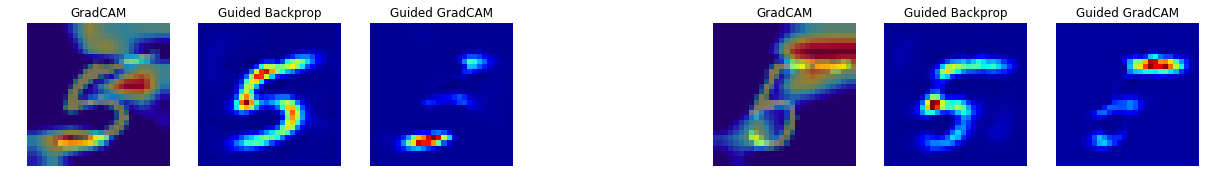

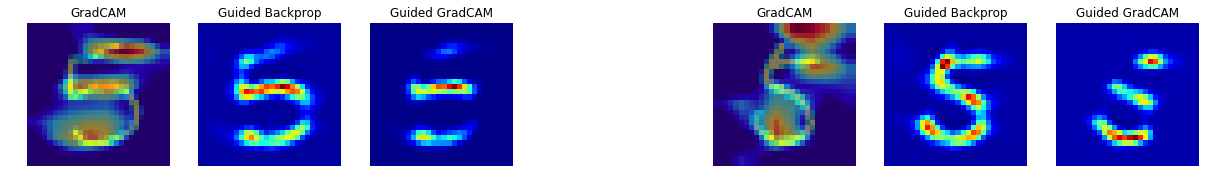

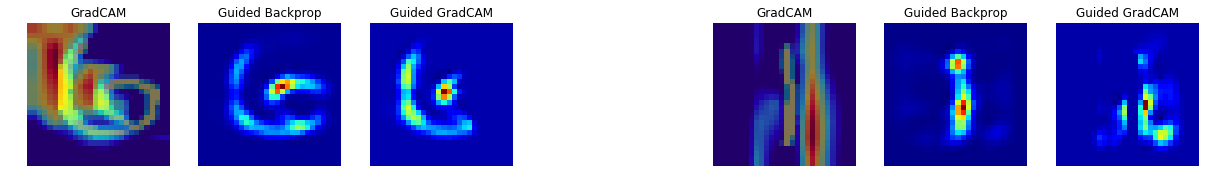

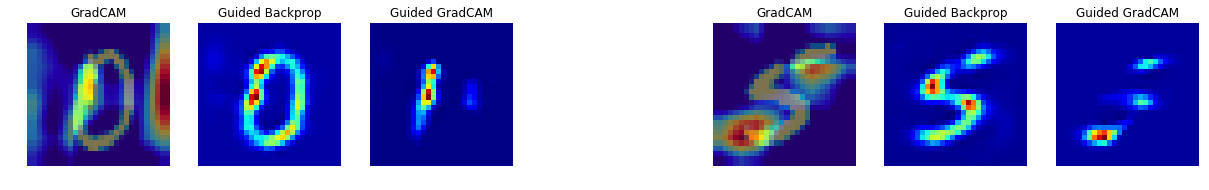

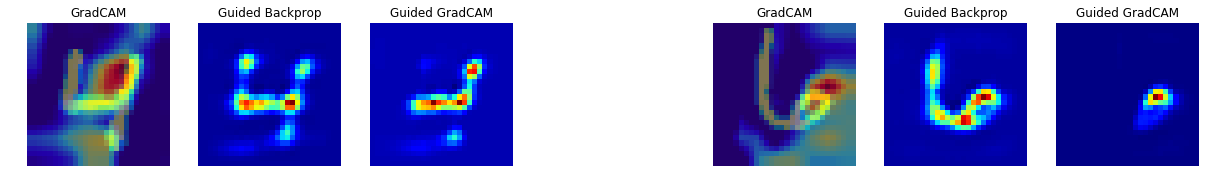

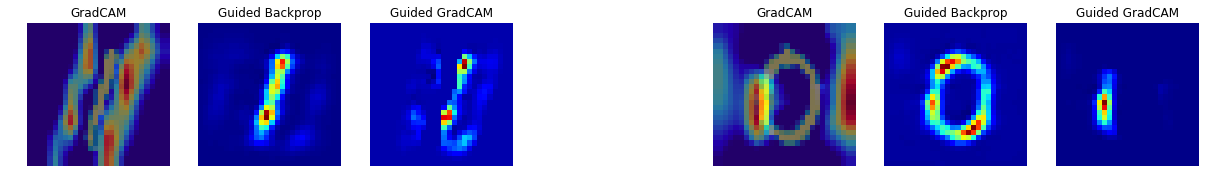

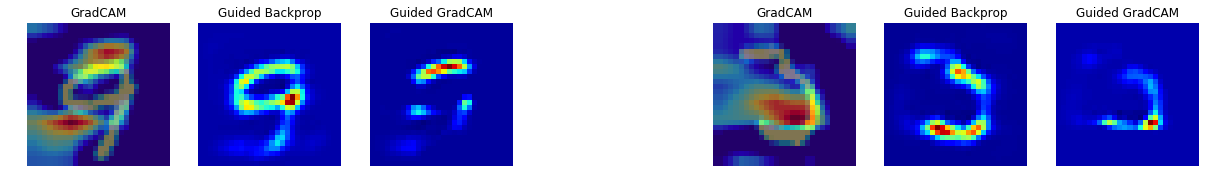

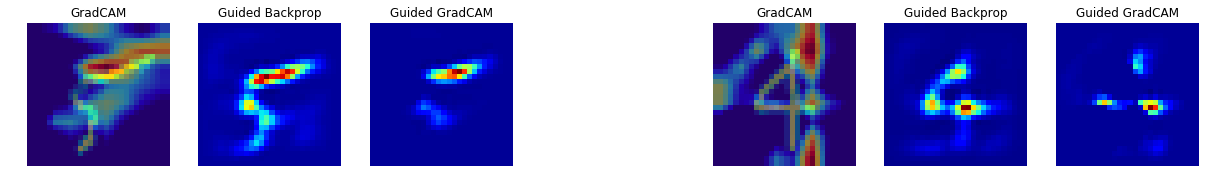

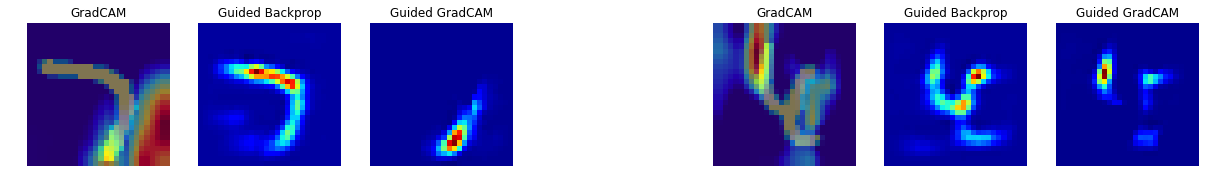

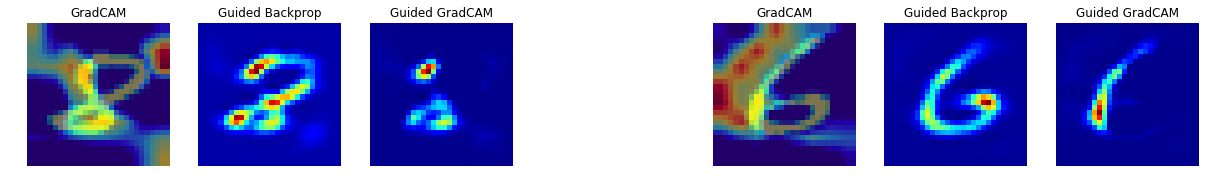

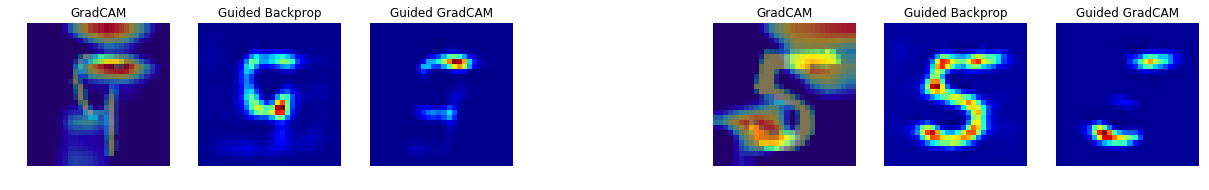

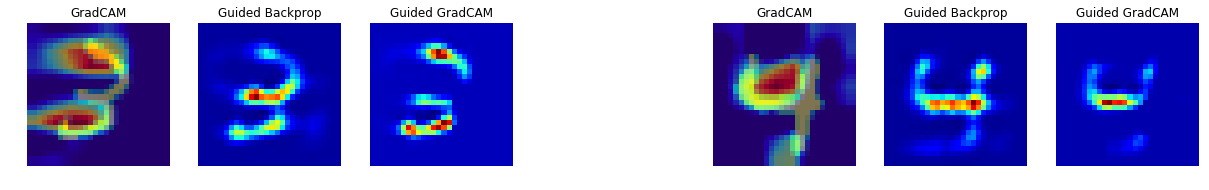

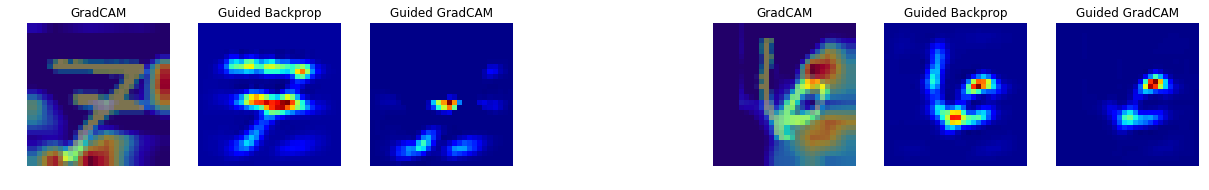

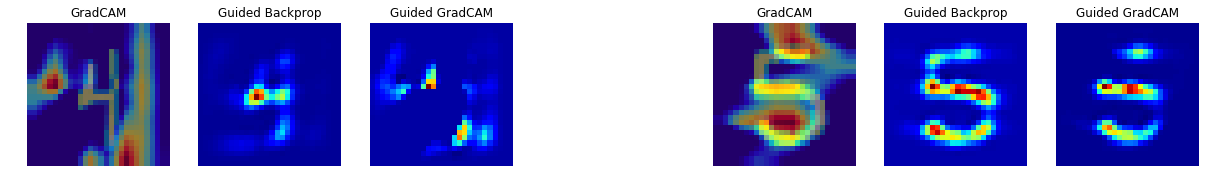

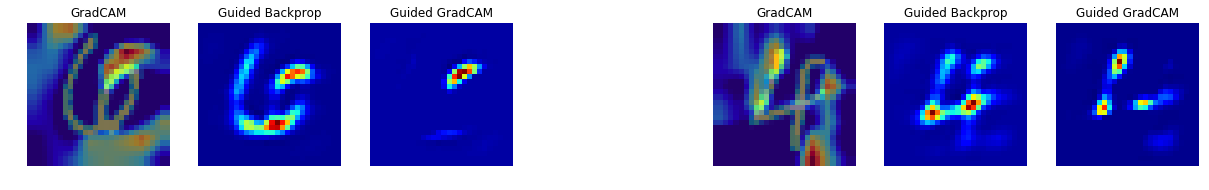

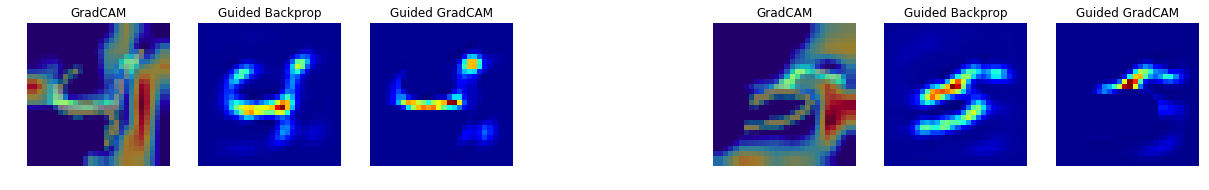

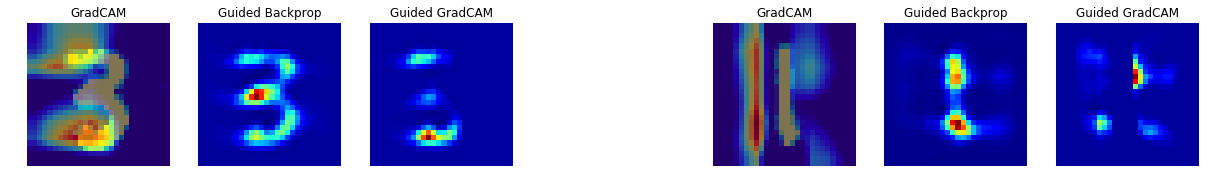

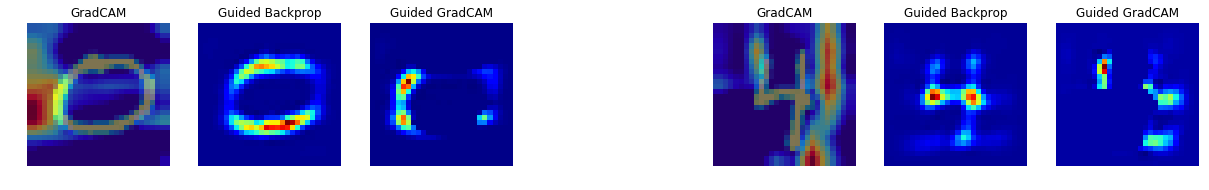

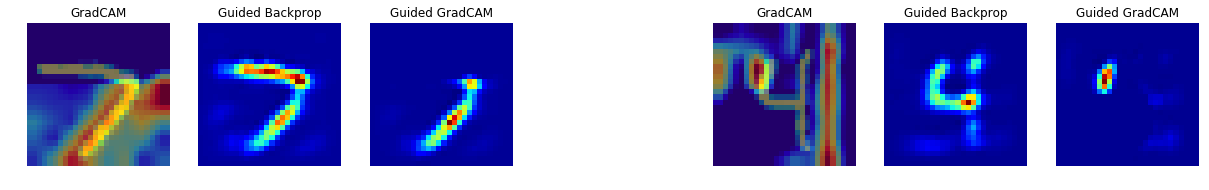

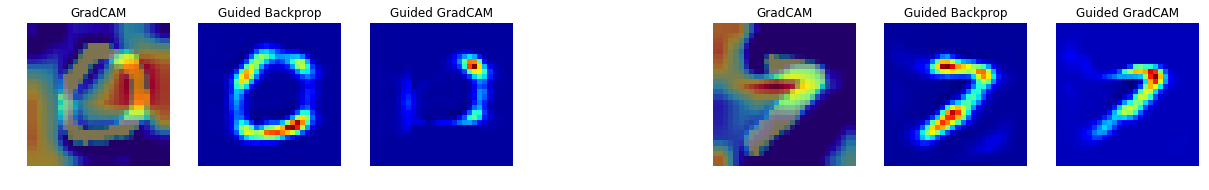

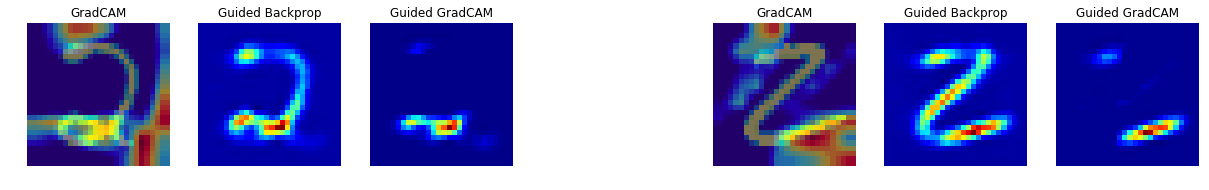

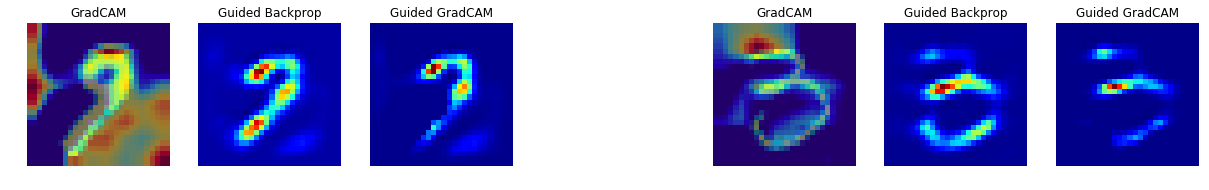

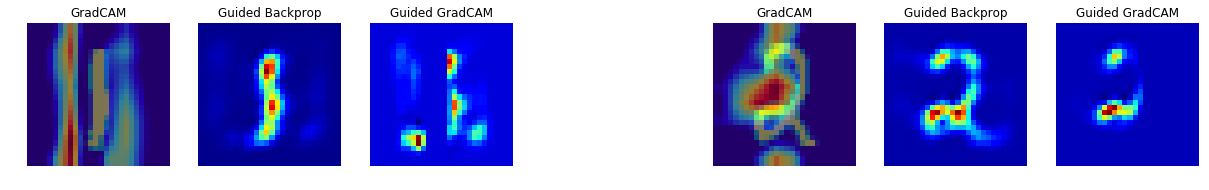

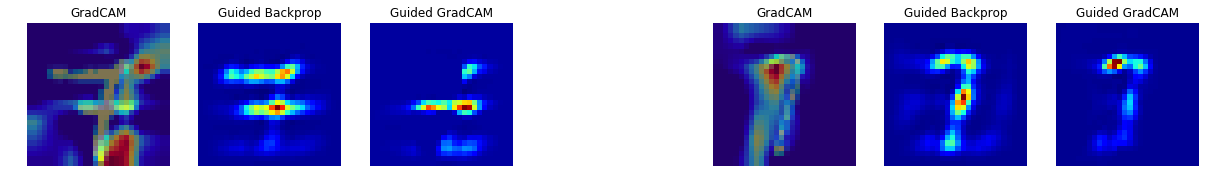

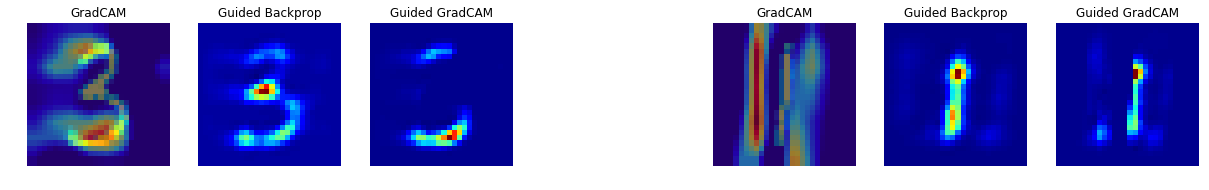

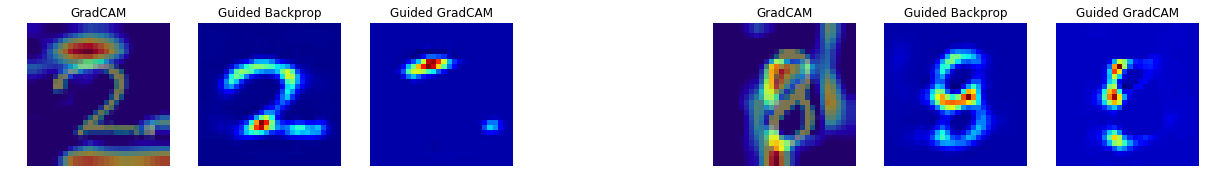

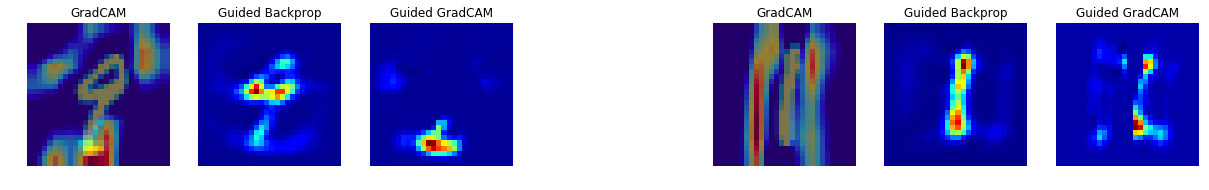

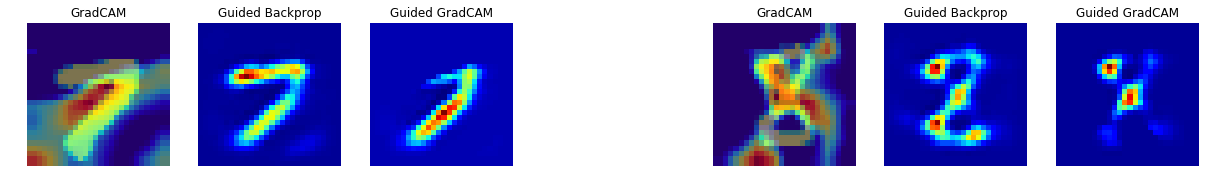

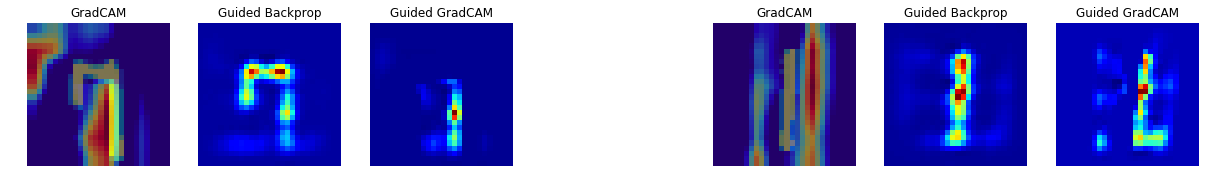

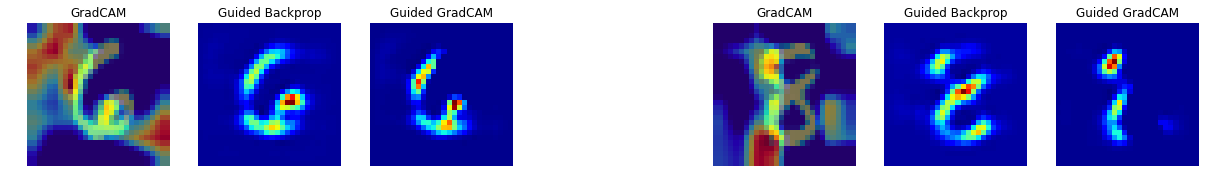

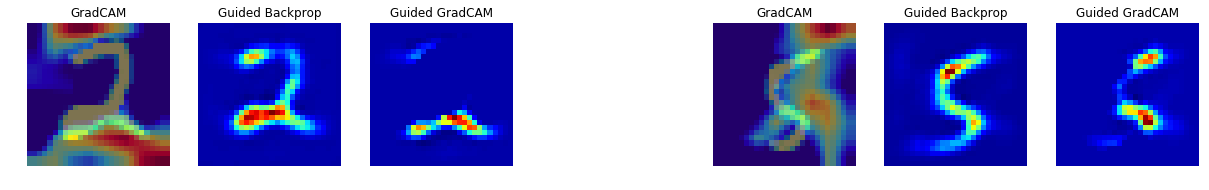

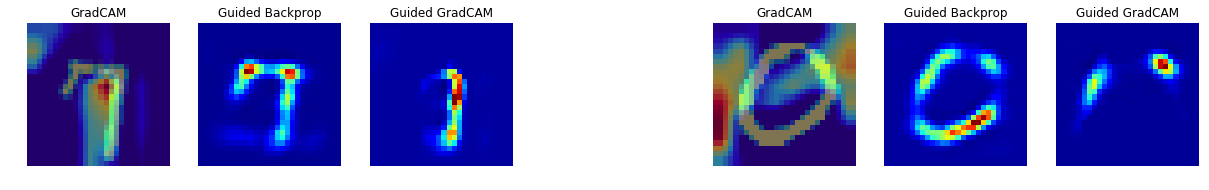

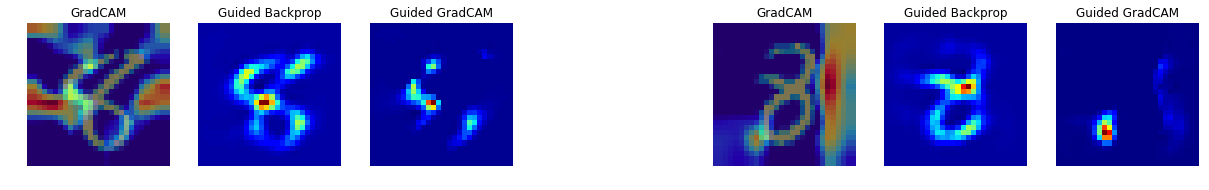

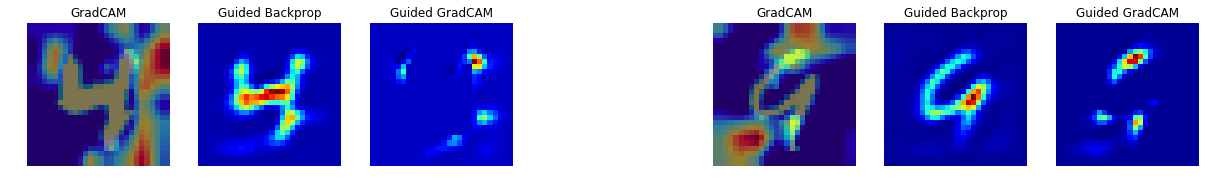

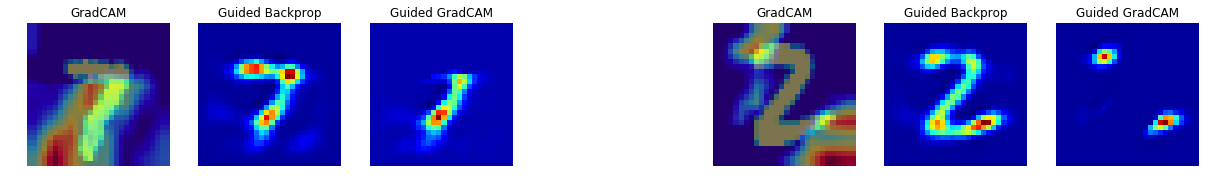

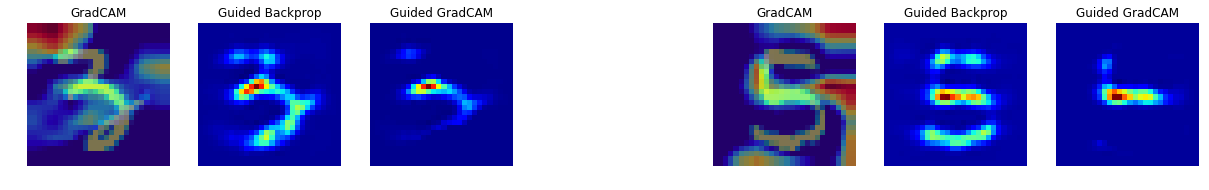

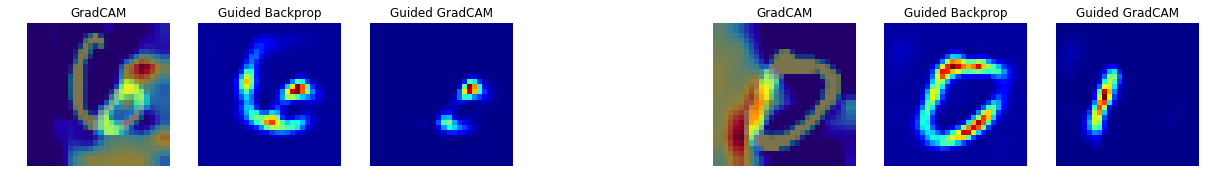

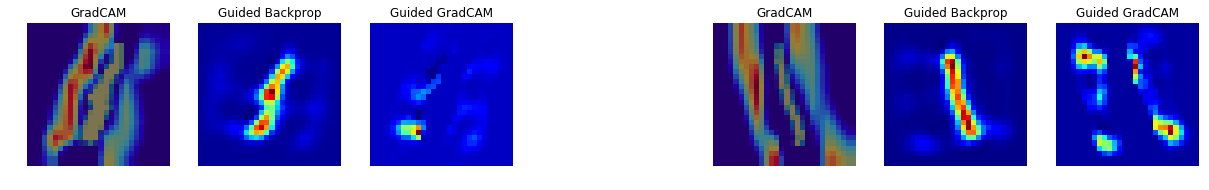

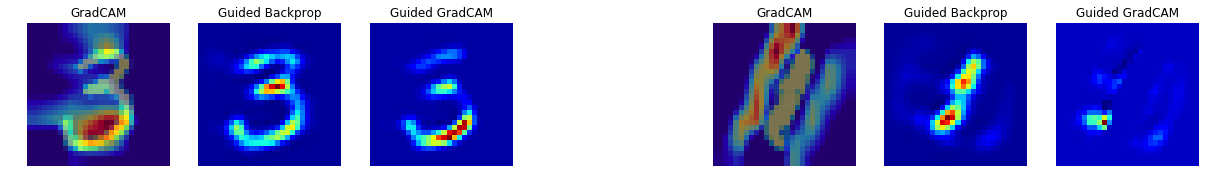

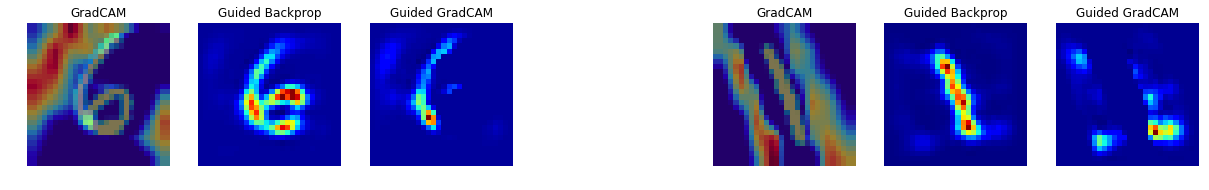

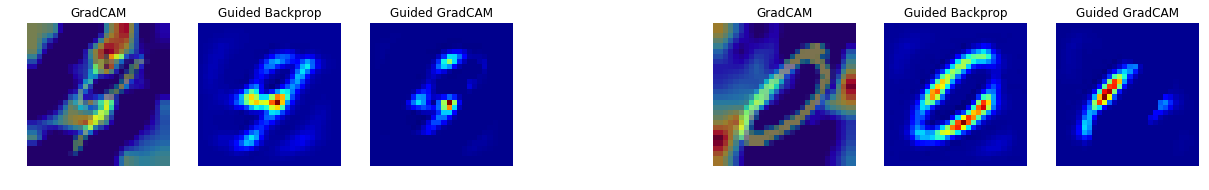

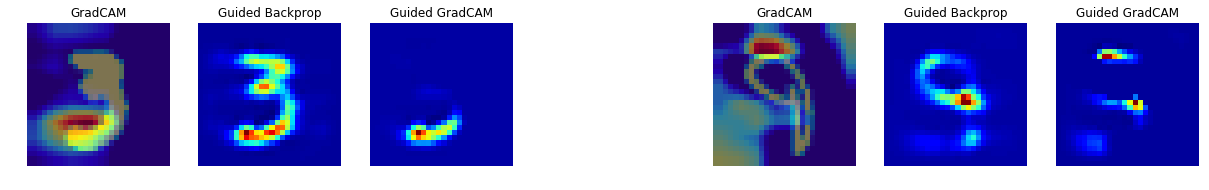

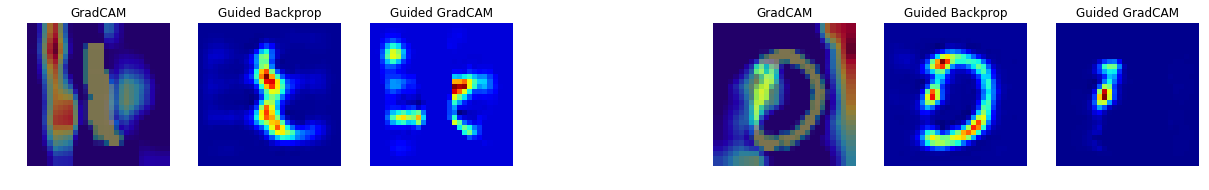

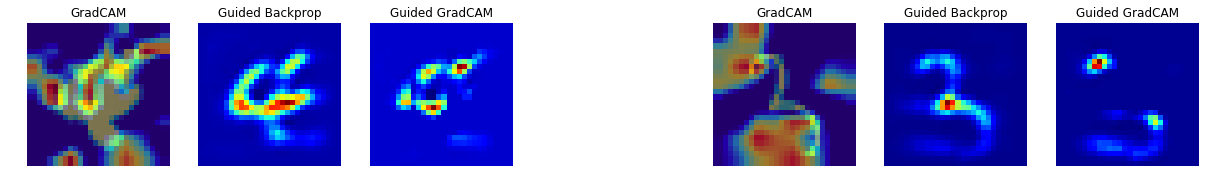

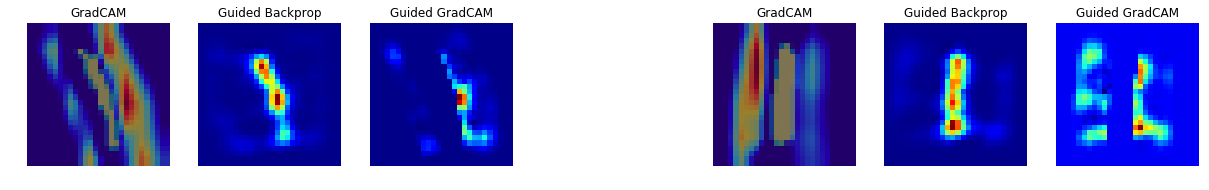

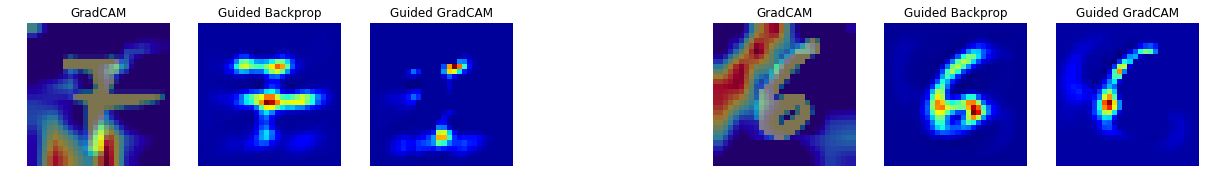

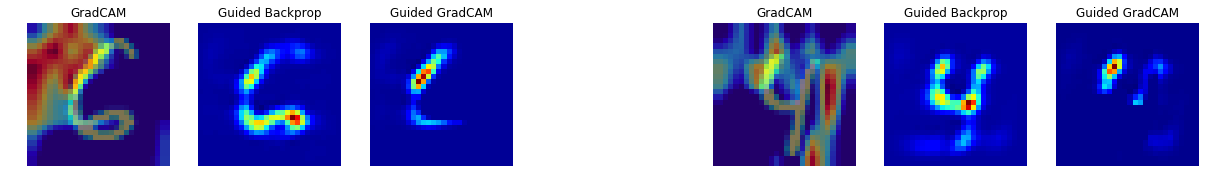

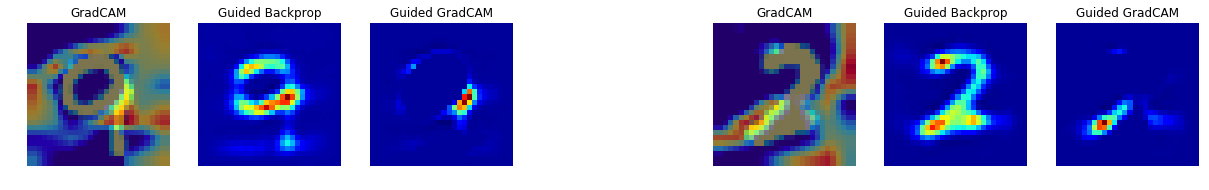

In [7]:
n = 100
for i in range(n):
    plt.figure(figsize=(21, 4))
    plt.subplot(171)
    plt.axis('off')
    plt.title('GradCAM')
    plt.imshow(x_test[i, :, :, 0])
    plt.imshow(gcs[i], cmap='jet', alpha=0.5)
    
    plt.subplot(172)
    plt.axis('off')
    plt.title('Guided Backprop')
    plt.imshow(gbs[i], cmap='jet')
    
    plt.subplot(173)
    plt.axis('off')
    plt.title('Guided GradCAM')
    plt.imshow(ggs[i], cmap='jet')
    
    
    
    plt.subplot(175)
    plt.axis('off')
    plt.title('GradCAM')
    plt.imshow(x_test[i+n, :, :, 0])
    plt.imshow(gcs[i+n], cmap='jet', alpha=0.5)
    
    plt.subplot(176)
    plt.axis('off')
    plt.title('Guided Backprop')
    plt.imshow(gbs[i+n], cmap='jet')
    
    plt.subplot(177)
    plt.axis('off')
    plt.title('Guided GradCAM')
    plt.imshow(ggs[i+n], cmap='jet')
    
    
    plt.show()

In [8]:
gcs.tofile('gradcam.npy')
gbs.tofile('guided_backprop.npy')
ggs.tofile('guided_gradcam.npy')